## Elastic Net Model Accuracy Comparison for some Stocks

---

|  |  |
|:---|:---|
|**Reading Time** |  10 minutes |
|**Packages used** | Defined with relevant DocStrings within repository   |
|**Model used** | Model already trained stored in the directory ./model/output|
|**Outcome** | Comparison of the model accuracy on the real dataset | 

---

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams

import warnings
warnings.filterwarnings("ignore") # just to remove clutter in the notebook

from datetime import date, datetime, timedelta
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
os.chdir("..")

In [3]:
from model.utils.pre_processing import create_features_and_target_split, standardize_and_limit_outliers_returns, add_technical_indicators

In [4]:
ticker = "SBIN.NS"
end_date = datetime.today()
start_date = date(2016, 1, 1)
df_hist = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [5]:
param = {'training_end': end_date - timedelta(seconds=2 * 365.2425 * 24 * 60 * 60),
             'validation_end': end_date - timedelta(seconds=1 * 365.2425 * 24 * 60 * 60),
             'past_day_returns_for_predicting': 21}

In [6]:
df_hist = add_technical_indicators(df_hist)
df_hist['daily_returns'] = df_hist['Adj Close'].pct_change()
df_hist = df_hist.dropna()
dt_model = create_features_and_target_split(pd.DataFrame(df_hist['daily_returns']),
                                                param['past_day_returns_for_predicting'])
dt_model = pd.merge(dt_model, df_hist, how="left", left_index=True, right_index=True)
technical_indicator_features = ['RSI', 'MACD', 'UpperBollingerBand', 'LowerBollingerBand']

In [7]:
X_train, Y_train, X_val, Y_val, scaler = standardize_and_limit_outliers_returns(dt_model, param['past_day_returns_for_predicting'], technical_indicator_features, **param)

In [8]:
model = ElasticNet(alpha=0, l1_ratio=0)
model.fit(X_train, Y_train)

ElasticNet(alpha=0, l1_ratio=0)

In [9]:
dt_model['actual_returns'] = dt_model['Adj Close'].pct_change()
dt_model = dt_model.dropna()
dt_model['predicted_returns'] = ""

In [10]:
df_training = dt_model[dt_model.index <= param['training_end']]
df_test = dt_model[dt_model.index > param['validation_end']]

### Based on updated features on a daily basis 

### Obvious issue in this is that it contains look ahead bias as we will not know the future features at time t=0, thus, better approach is to do multi-step forecasting and then compare.

---

In [11]:
rol_freq = param['past_day_returns_for_predicting']
for i in range(0, len(df_test) - 1):
    features_ls = np.concatenate((df_test.iloc[i, :rol_freq].values, df_test.iloc[i][technical_indicator_features].values))
    features_ls = features_ls.reshape(-1,1)
    new_scaled_ls = scaler.transform(features_ls.T)
    predicted_return = model.predict(new_scaled_ls)[0]
    df_test.iloc[i+1, df_test.columns.get_loc('predicted_returns')] = predicted_return

In [27]:
df_test_subset = df_test[['actual_returns', 'predicted_returns']]
df_test_subset['Actual'] = ""
df_test_subset['Predicted'] = ""

In [28]:
st_ind = df_test_subset.index[0]
df_test_subset.loc[st_ind, 'Actual'] = 100
df_test_subset.loc[st_ind, 'Predicted'] = 100

In [29]:
i = 1
for ind in df_test_subset.index[1:]:
    df_test_subset.loc[ind,'Actual'] = df_test_subset.iloc[i - 1]['Actual'] * (1 + df_test_subset.iloc[i]['actual_returns'])
    df_test_subset.loc[ind,'Predicted'] = df_test_subset.iloc[i - 1]['Predicted'] * (1 + df_test_subset.iloc[i]['predicted_returns'])
    i+=1

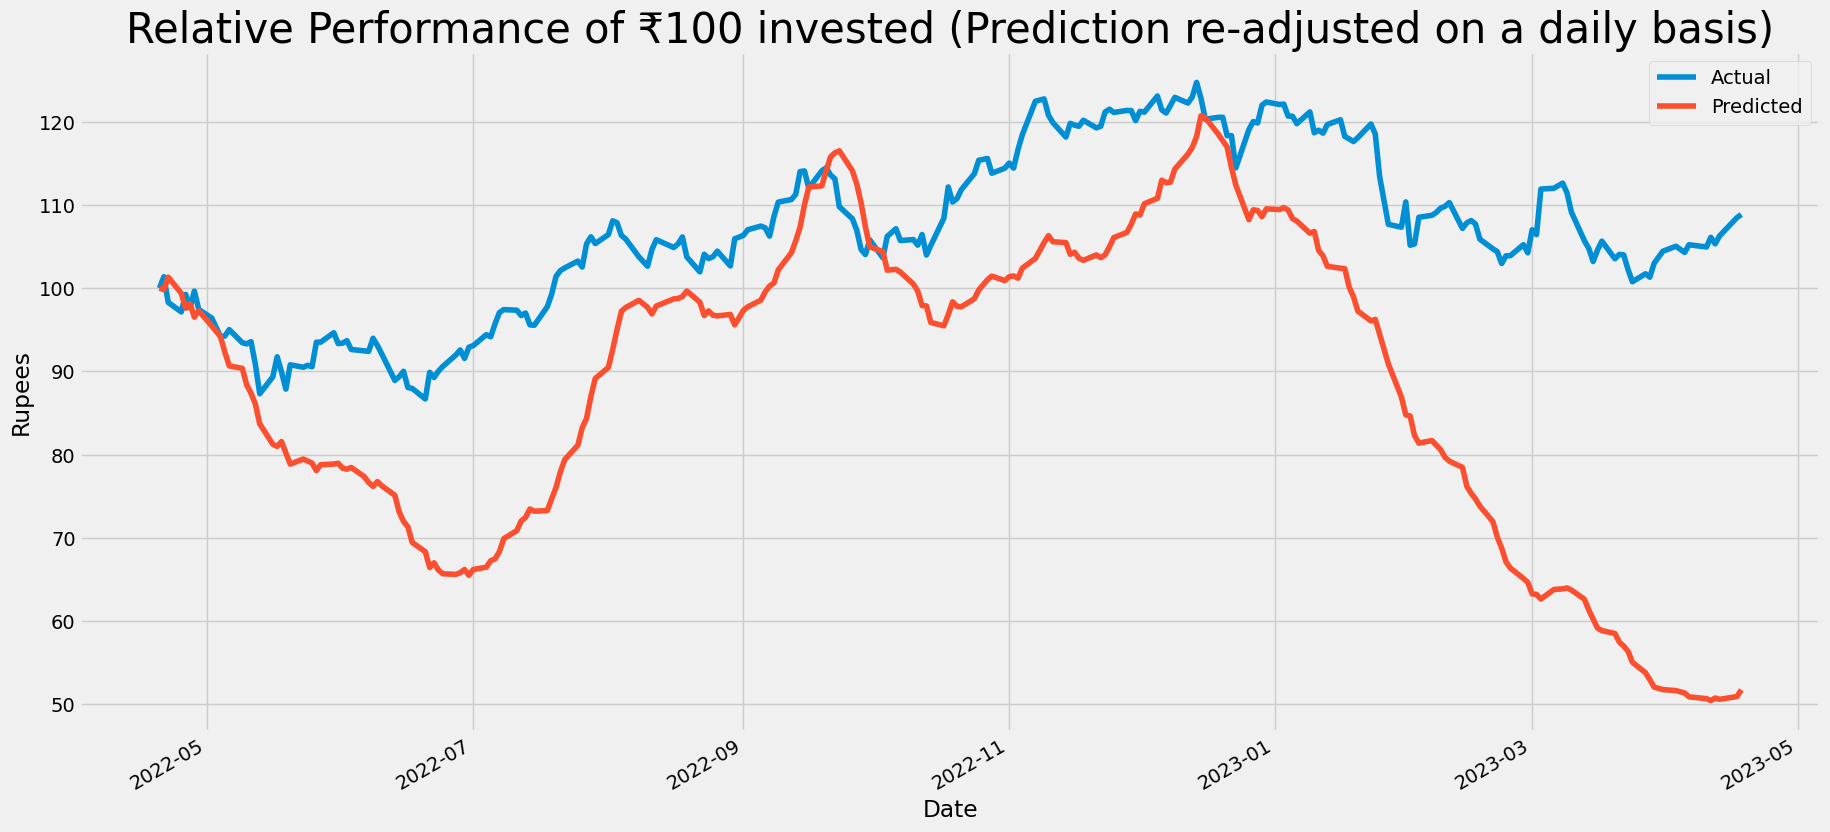

In [30]:
df_test_subset.plot(y = ['Actual', 'Predicted'], figsize=(20,10))
plt.title("Relative Performance of ₹100 invested (Prediction re-adjusted on a daily basis)", fontsize=30)
plt.xlabel("Date")
plt.ylabel("Rupees");

In [57]:
rol_freq_for_prediction = param['past_day_returns_for_predicting']
for i in range(rol_freq_for_prediction, len(df_training)):
    features_ls = np.array(df_training.iloc[i - rol_freq_for_prediction:i, 0:df_training.shape[1]]['actual_returns'].to_list())
    features_ls = features_ls.reshape(-1,1)
    new_scaled_ls = scaler.transform(features_ls.T)
    predicted_return = model.predict(new_scaled_ls)[0]
    df.iloc[i, df.columns.get_loc('rolling_returns')] = predicted_return
    df.iloc[i, df.columns.get_loc('predicted_returns')] = predicted_return

In [ ]:
for i in range(rol_freq_for_prediction, len(df_test)):
    features_ls = np.array(df_training.iloc[i - rol_freq_for_prediction:i, 0:df_training.shape[1]]['actual_returns'].to_list())
    features_ls = features_ls.reshape(-1,1)
    new_scaled_ls = scaler.transform(features_ls.T)
    predicted_return = model.predict(new_scaled_ls)[0]
    df_training.iloc[i, df_training.columns.get_loc('predicted_returns')] = predicted_return